## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


#### Part I - Probability


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.shape[0]

294478

In [4]:
df.user_id.nunique()

290584

In [5]:
df.converted.mean()

0.11965919355605512

In [6]:
df.query('(group == "treatment" and landing_page != "new_page") or (group == "control" and landing_page == "new_page")').shape[0]

3893

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [8]:
df2 = df.query('(group=="treatment" and landing_page == "new_page") or (group == "control" and landing_page == "old_page")')

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
df2.user_id.nunique()

290584

In [11]:
df2[df2.duplicated("user_id")]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [12]:
df2[df2.duplicated(["user_id"], keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
df2 = df2.drop_duplicates("user_id")

In [14]:
df2.converted.mean()

0.11959708724499628

In [15]:
df2[df2["group"] == "control"].converted.sum()/df2[df2["group"] == "control"].shape[0]

0.1203863045004612

In [16]:
df2[df2["group"] == "treatment"].converted.sum()/df2[df2["group"] == "treatment"].shape[0]

0.11880806551510564

In [17]:
df2[df2.landing_page == "new_page"].shape[0]/df2.shape[0]

0.5000619442226688

**From the above results we know that there is no sufficient evidence that the treatment page leads to more conversions. In contrast, we can see that control page has higer conversions based on the above results.** 

<a id='ab_test'></a>
### Part II - A/B Test

**$H_{0}$  =  $p_{new}$ -  $p_{old}$ ≤ 0**

**$H_{1}$  =  $p_{new}$  -  $p_{old}$  > 0**

**convert rate** for $p_{new}$ under the null

In [18]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

**convert rate** for $p_{old}$ under the null

In [19]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

In [20]:
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

In [21]:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[1-p_new, p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[1-p_old, p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

Find $p_{new}$ - $p_{old}$ for my simulated values from part (e) and (f).

In [24]:
new_page_converted.mean() - old_page_converted.mean()

-0.0017711282956616448

Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
new_converted_simulation = np.random.binomial(n_new, p_new,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old,  10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

Plot a histogram of the **p_diffs**.  

(array([   8.,   78.,  438., 1577., 2958., 2906., 1559.,  408.,   64.,
           4.]),
 array([-4.87506442e-03, -3.89154460e-03, -2.90802478e-03, -1.92450496e-03,
        -9.40985144e-04,  4.25346754e-05,  1.02605449e-03,  2.00957431e-03,
         2.99309413e-03,  3.97661395e-03,  4.96013377e-03]),
 <a list of 10 Patch objects>)

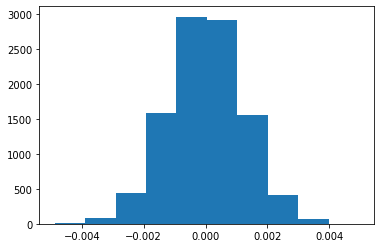

In [26]:
plt.hist(p_diffs)

In [27]:
actual_diff = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()
actual_diff

-0.0015782389853555567

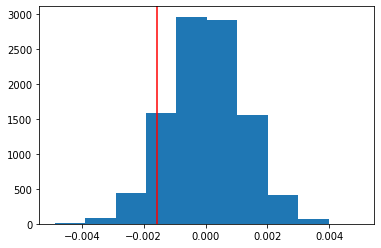

In [28]:
plt.hist(p_diffs)
plt.axvline(actual_diff, color = 'r')

In [29]:
p_diffs = np.array(p_diffs)
p_val = (p_diffs > actual_diff).mean()
p_val

0.9084

**From above results, we notice that the p value is about 0.907 which is larger than 0.05. It suggests that the the difference between the new and old pages is not significant difference. Therefore, we fail to reject the null hypothesis.**

We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm
convert_old = df2.query('landing_page == "old_page" and converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" and converted == 1').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

In [31]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


In [32]:
from scipy.stats import norm
# Tells us how significant our z-score is
print(norm.cdf(z_score))

# for our single-sides test, assumed at 95% confidence level, we calculate: 
print(norm.ppf(1-(0.05)))

0.09494168724097551
1.6448536269514722


**From above results, we found that z-score is about -1.311 which is less than the critical value which is about 1.645, so we failed to reject the null hypothesis. For p-value which is about 0.095 which is larger than 0.05, so we also fail to reject the null hypothesis. From these two observations, I think they agree with the findings in parts j and k because they are the same.**

<a id='regression'></a>
### Part III - A regression approach

**Logistic Regression**

In [33]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


c. Use **statsmodels** to import my regression model.  Instantiate the model, and fit the model using the two columns I created in part to predict whether or not an individual converts.

In [34]:
df2['intercept'] = 1
df2[['control', 'treatment']] = pd.get_dummies(df2.group)
#df2.head()
logit = sm.Logit(df2.converted, df2[['intercept', 'treatment']])
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [35]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 17 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        18:33:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**The p-value for ab_page is 0.190. And the reson why it differs from the value in Part II is because it is an one-side test in Part II and two-side test in PART III.**

**It might be an good idea to add other factors into our model. For example, age and gender might influence the conversion rate as well for the old page or new page.**

**Although considering adding other factors into the model might provide more insights for us, I do think it there might be some disadvantages such as if variables are dependable with each other. And we also need to consider other potentional issues exists such as correlation of error terms, non-constant Variance and Normall Distributed Errors, outliers/high leverage points and so on.**

In [36]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [37]:
### Create the necessary dummy variables
countries_dummies = pd.get_dummies(df_new['country'])
df_countries = df_new.join(countries_dummies)
df_countries = df_countries.drop(['country', 'CA'], axis=1)
df_countries.head()

,timestamp,group,landing_page,converted,intercept,control,treatment,UK,US
user_id,,,,,,,,,
834778,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,1,0
928468,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,1
822059,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,1,0
711597,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,1,0
710616,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,1,0


In [38]:
### Fit Your Linear Model And Obtain the Results
logit = sm.Logit(df_countries['converted'], df_countries[['intercept', 'UK', 'US']])
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 17 Jun 2020   Pseudo R-squ.:               1.521e-05
Time:                        18:33:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

In [39]:
np.exp(results.params)

intercept    0.130350
UK           1.052027
US           1.041647
dtype: float64

## Conclusions

**In Part II, the results tell us that we fail to reject the null hypothesis which is the old page was more effective or equally as effective at converting users than the new page.** 

**In Part III, the results also tell us that we fail to reject the null hypothesis which is the same as in Part II. In Part III, because the response variables are categorical variables, I decided to use logistic regresssion. And the result also tell us that we fail to reject the null hypothesis.**

**Base on above tests, we can make a conclusion that there is no supporting evidence for launching the new page becuase the conversion rate don't raise up.** 